In [128]:
import torch
import torchviz
import os
import torch.nn as nn
import pandas as pd
import numpy as np      
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torch.utils.data import WeightedRandomSampler, RandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [129]:
# import dataset
df = pd.read_csv("../3 - Cleaning & Transforming Data/2 cleaned_dataset_MERGED_DRUG(Mogran)_ALLELESEQ.csv", index_col = None)

if(df.isna().any().sum()) != 0:
    raise Exception('There are still missing values in the dataset!')

In [130]:
# check ของแปลกที่หลุดเข้ามา
for x in df.columns:
    print(x)

Drug
Allele
ADR_MPexanthema
ADR_SJS
ADR_TEN
ADR
Cohort ethnicity_Black
Cohort ethnicity_Caucasian
Cohort ethnicity_Diverse
Cohort ethnicity_Mongol
Cohort ethnicity
No_ADR
Yes_ADR
0
1
2
3
4
11
20
23
30
74
80
86
122
123
130
140
151
162
175
191
204
207
245
248
264
294
297
300
314
315
319
323
333
336
338
350
352
366
371
378
381
389
405
409
426
428
435
448
456
461
469
470
485
486
501
502
511
527
530
535
547
554
556
561
588
600
609
623
624
631
637
650
656
675
679
694
713
715
725
739
745
750
751
764
770
772
780
787
794
798
806
807
833
834
843
849
872
875
882
883
884
888
926
935
952
974
984
987
990
993
1011
1017
1019
1028
1039
1043
1044
1055
1057
1060
1066
1070
1077
1088
1097
1098
1099
1102
1105
1114
1120
1130
1137
1138
1142
1145
1148
1152
1153
1155
1164
1168
1171
1182
1184
1199
1212
1236
1242
1267
1269
1270
1292
1295
1312
1313
1318
1325
1340
1347
1351
1357
1380
1389
1391
1398
1426
1428
1434
1446
1448
1449
1452
1457
1459
1464
1476
1480
1498
1528
1535
1542
1544
1564
1578
1585
1589
1602
1607
164

In [131]:
df['ADR'].value_counts()

SJS            5805
TEN            3738
MPexanthema    3530
Name: ADR, dtype: int64

In [132]:
# Drop unnecessary columns
df_stratify = pd.DataFrame()
df['ADR'] = df['ADR'].replace({'SJS': 0, 'TEN': 1, 'MPexanthema':2})#,'MPeruption':3})
#df = df[df['ADR'].isin([0,1])] #ลบ MP ออก
#df_stratify['Yes_ADR'] = df['ADR'].copy()
#df_stratify = df_stratify.rename(columns={'Yes_ADR':'ADR'})
df.drop(columns=['No_ADR','ADR','ADR_MPexanthema','ADR_SJS','ADR_TEN','Cohort ethnicity','Allele','Drug'], inplace=True) #'MPeruption' removed

In [133]:
# Select output columns and drop unnecessary columns
df_output = df['Yes_ADR'].copy()
df.drop(columns = ['Yes_ADR'], inplace = True)
df_input = df.copy()
# Check input dtypes
df_input.dtypes.value_counts()

int64    350
dtype: int64

In [134]:
# check ของแปลกที่หลุดเข้ามา
df_output

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
13068    0.0
13069    0.0
13070    0.0
13071    0.0
13072    0.0
Name: Yes_ADR, Length: 13073, dtype: float64

In [135]:
# check ของแปลกที่หลุดเข้ามา
for x in df_input.columns:
    print(x)

Cohort ethnicity_Black
Cohort ethnicity_Caucasian
Cohort ethnicity_Diverse
Cohort ethnicity_Mongol
0
1
2
3
4
11
20
23
30
74
80
86
122
123
130
140
151
162
175
191
204
207
245
248
264
294
297
300
314
315
319
323
333
336
338
350
352
366
371
378
381
389
405
409
426
428
435
448
456
461
469
470
485
486
501
502
511
527
530
535
547
554
556
561
588
600
609
623
624
631
637
650
656
675
679
694
713
715
725
739
745
750
751
764
770
772
780
787
794
798
806
807
833
834
843
849
872
875
882
883
884
888
926
935
952
974
984
987
990
993
1011
1017
1019
1028
1039
1043
1044
1055
1057
1060
1066
1070
1077
1088
1097
1098
1099
1102
1105
1114
1120
1130
1137
1138
1142
1145
1148
1152
1153
1155
1164
1168
1171
1182
1184
1199
1212
1236
1242
1267
1269
1270
1292
1295
1312
1313
1318
1325
1340
1347
1351
1357
1380
1389
1391
1398
1426
1428
1434
1446
1448
1449
1452
1457
1459
1464
1476
1480
1498
1528
1535
1542
1544
1564
1578
1585
1589
1602
1607
1646
1647
1657
1675
1683
1708
1722
1738
1739
1742
1750
1778
1786
1803
1804
1816
182

In [136]:
# # Change all input dtypes to float64
# df_input = df_input.astype('float64')
# df_input.dtypes.value_counts()

In [144]:
# Convert to numpy array
np_input = df_input.to_numpy()
np_output = df_output.to_numpy()
np_stratify = df_stratify.to_numpy()

In [138]:
pd.DataFrame(np_stratify).value_counts()

Series([], dtype: int64)

In [139]:
np_input    

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [140]:
# Function to check dataloader classes distribution
def get_dataloader_distribution(*args, label = None):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(target.numpy()).value_counts()
            batch_count.append(i+1)
            try:
                class_0_count.append(tocount[0])
            except:
                class_0_count.append(0)
            try:
                class_1_count.append(tocount[1])
            except:
                class_1_count.append(0)
        X_axis = np.arange(len(batch_count))

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis+(1/3),class_0_count,width=(1/3) ,label = "No ADR",color='red',alpha=0.5)
        ax[index].bar(X_axis,class_1_count,width=(1/3), label = 'Yes ADR',color='green',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()
    
    ax[0].set_title(f"{label} Train_Loader Label Distribution by Yes/No ADR (per batch)")
    ax[1].set_title(f"{label} Test_loader Label Distribution by Yes/No ADR")
    ax[1].set_xticks([])
    plt.show()

In [145]:
print(np_input.shape)
print(np_output.shape)

(13073, 350)
(13073,)


In [146]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

## Define Model

In [147]:
# Define Network Classes
class Network(nn.Module):
    def __init__(self, n_layers, n_first_units, dropout):
        super().__init__()

    # Define Layers    
        layers = []
        in_features = np_input.shape[1]
        out_features = n_first_units 
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        in_features = out_features
        for i in range(n_layers): #i หมายถึงเลขชั้น hidden+1

            layers.append(nn.BatchNorm1d(in_features))
            out_features = int(in_features/2)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_features = out_features
        layers.append(nn.BatchNorm1d(out_features))
        layers.append(nn.Linear(out_features, 1)) 
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)

    # Define the forward pass
    def forward(self,input):
        output = self.layers(input)
        return output


In [148]:
# Empty CUDA cache
torch.cuda.empty_cache()

# Assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [149]:
# Define train function

def train(dataloader, model, loss_fn, optimizer):

    
    # Running Loss and Train Accuracy 
    running_loss = []
    running_train_acc = []

    # Set model to train mode
    model.train()

    # Loop through dataloader
    for batch_idx, (data, target) in enumerate(train_loader):

        # Move data to device
        data = data.float().to(device)
        target = target.float().to(device)
        
        # Save Model Graph
        if batch_idx == 0:
            dot = torchviz.make_dot(model(data), show_attrs=True, show_saved = True,params=dict(model.named_parameters()))
            dot.render(f'{dir}/{name}')

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        
        # Calculate loss
        output = output.flatten()         
        loss = loss_fn(output,target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Save loss for each batch
        running_loss.append(loss.item()) 

        # Calculate accuracy
        with torch.no_grad():
            target = target.flatten()
            output = torch.round(output)
            correct = (output == target).sum().item()
            train_acc = correct/len(target)
            train_acc = round(train_acc, 8)
            running_train_acc.append(train_acc)

    train_acc = np.mean(running_train_acc)
    train_loss = np.mean(running_loss)
    #print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    return float(train_loss), float(train_acc)

In [150]:
# Define test function

def test(dataloader, model, loss_fn):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            # Move data to device
            data = data.float().to(device)
            target = target.float().to(device)    
            
            # Forward pass           
            output = model(data)

            # Calculate loss
            output = output.flatten()
            data = data.flatten()
            
            test_loss = loss_fn(output, target)

            # Calculate accuracy
            output = torch.round(output)
            correct = (output == target).sum().item()

        output = output.cpu().detach().numpy()
        target = target.cpu().detach().numpy()

        # Calculate metrics
        test_acc = correct / len(test_loader.dataset)
        test_loss = test_loss.cpu().detach().numpy()
        test_precision = precision_score(output, target, zero_division=0)
        test_f1_score = f1_score(output, target, zero_division=0)
        test_recall_score = recall_score(output, target, zero_division=0)
    #print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall_score:.4f}, Test F1 Score: {test_f1_score:.4f}")

    return float(test_loss), float(test_acc), float(test_precision), float(test_recall_score), float(test_f1_score)

In [161]:
# Standard

# Create model
model = Network(4, 512, 0.2).to(device)
print(model)

# Define Hyperparameters
batch_size = 512
learning_rate = 1e-3
epochs = 10
L2lambda = 0.01
k_folds = 10

# Assign Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2lambda)

# Assign Loss Function
loss_fn = nn.BCELoss()

# Assign Run Name
name = f"k-fold_test1"
dir = os.path.join('runs', name)
#writer = SummaryWriter()

# Create K-Fold and lock Random Seed
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=123)
torch.manual_seed(123)

total_train_loss = []
total_test_loss = []
total_train_acc = []
total_test_acc = []
total_test_f1 = []
total_test_precision = []
total_test_recall = []

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(np_input,np_output)):
    
    # Reset model   
    model.apply(reset_weights)

    fold_train_loss = []
    fold_test_loss = []
    fold_train_acc = []
    fold_test_acc = []
    fold_test_f1 = []
    fold_test_precision = []
    fold_test_recall = []

    # Check disjoint for each fold จ้า
    for x in train_ids: 
        if x in test_ids:
            raise Exception("WARNING: Train and Test IDs are not disjoint!")

    # Print Fold
    print(f'FOLD {fold}')   
    print(f'--------')   

    # Create data for each fold with the index provided by kfold.split
    np_fold_train_input = np_input[train_ids]
    np_fold_train_output = np_output[train_ids]
    np_fold_test_input = np_input[test_ids]
    np_fold_test_output = np_output[test_ids]

    # Create Weight for Sampler
    weight = (1/pd.DataFrame(np_fold_train_output).value_counts()).tolist()
    sample_weights = np.array([weight[int(t)] for t in np_fold_train_output])

    # Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)
    #train_sampler = RandomSampler(np_fold_train_output) #RandomSampler จะทำให้เห็นว่า class มัน imbalance ยังไง

    # Create Dataset and Dataloader
    train_dataset = TensorDataset(torch.from_numpy(np_fold_train_input).float(), torch.from_numpy(np_fold_train_output).float())
    test_dataset = TensorDataset(torch.from_numpy(np_fold_test_input).float(), torch.from_numpy(np_fold_test_output).float())
    train_loader = DataLoader(train_dataset, batch_size=batch_size , sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=len(test_ids))
    #get_dataloader_distribution(train_loader,test_loader,label=f'Fold {fold}') #ใช้เช็ค Distribution ของแต่ละ Fold

    # Train / Test Loops
    for t in range(epochs):

        train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc, test_precision, test_recall, test_f1 = test(test_loader, model, loss_fn)
        print(f"epoch: {t}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}, test precision: {test_precision:.4f}, test recall: {test_recall:.4f}, test f1: {test_f1:.4f}")
        fold_train_loss.append(train_loss)
        fold_test_loss.append(test_loss)
        fold_train_acc.append(train_acc)
        fold_test_acc.append(test_acc)
        fold_test_f1.append(test_f1)
        fold_test_precision.append(test_precision)
        fold_test_recall.append(test_recall)
        with tf.summary.create_file_writer(f"{dir}_train_fold{fold}").as_default():
            tf.summary.scalar("loss", train_loss, step=t)
            tf.summary.scalar("acc", train_acc, step=t)
        with tf.summary.create_file_writer(f"{dir}_test_fold{fold}").as_default():    
            tf.summary.scalar("loss", test_loss, step=t) 
            tf.summary.scalar("acc", test_acc, step=t)
            tf.summary.scalar("precision", test_precision, step=t)
            tf.summary.scalar("f1_score", test_f1, step=t)
            tf.summary.scalar("recall_score", test_recall, step=t)

    # Added last value of each fold to total list
    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)
    total_train_acc.append(train_acc)
    total_test_acc.append(test_acc)
    total_test_f1.append(test_f1)
    total_test_precision.append(test_precision)
    total_test_recall.append(test_recall)

print("Training Done")
print(f"K-FOLD CROSS VALIDATION FOR {k_folds} FOLDS, IN {epochs} EPOCHS")
print(f"Total Train Loss: {np.mean(total_train_loss):.5f}")
print(f"Total Test Loss: {np.mean(total_test_loss):.5f}")
print(f"Total Train Acc: {np.mean(total_train_acc):.5f}")
print(f"Total Test Acc: {np.mean(total_test_acc):.5f}")
print(f"Total Test Precision: {np.mean(total_test_precision):.5f}")
print(f"Total Test Recall: {np.mean(total_test_recall):.5f}")
print(f"Total Test F1: {np.mean(total_test_f1):.5f}")

#หากรันจบให้เซฟโมเดลเก็บไว้ด้วยจร้า

# torch.save(model.state_dict(),f"../4 - Training & Testing/{dir}/{name}")
# model_tosave = torch.jit.script(model)
# model_tosave.save(f"../4 - Training & Testing/{dir}/{name}")

# save_modeljingjing(name)
# save_graphs(name,total_train_acc,total_test_acc,total_train_loss,total_test_loss)
# save_CFmatrix(name)
# save_PRAUC(name)
# save_model(name,optimizer,loss_fn)

Network(
  (layers): Sequential(
    (0): Linear(in_features=350, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Linear(in_features=64, out_features=32, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.2, inplace=False)
    (19): BatchNo

## Create two type of dataloader, อันนึง weighted อีกอัน unweighted

In [15]:
def get_dataloaders(batch_size):

    # Train Test Splits
    X_train, X_test, y_train, y_test = train_test_split(np_input, np_output, test_size = 0.2, random_state = 128, stratify = np_stratify, shuffle = True)

    # See Distribution
    print('BEFORE applying weight train_label data distribution 0/1: {}/{}'.format(
    len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))

    print('BEFORE applying weight test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0])))

    # Find Weight of each class in train_labels
    weight = (1/pd.DataFrame(y_train).value_counts()).tolist()
    sample_weights = np.array([weight[int(t)] for t in y_train])

    # Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)

    # Create TensorDataset
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0])

    return train_loader, test_loader

In [16]:
def get_dataloaders_NOweight(batch_size):

    # Train Test Splits
    X_train, X_test, y_train, y_test = train_test_split(np_input, np_output, test_size = 0.2, random_state = 128, stratify = np_stratify, shuffle = True)

    # See Distribution
    print('BEFORE applying weight train_label data distribution 0/1: {}/{}'.format(
    len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))

    print('BEFORE applying weight test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0])))

    # Find Weight of each class in train_labels
    weight = (1/pd.DataFrame(y_train).value_counts()).tolist()
    sample_weights = np.array([weight[int(t)] for t in y_train])

    # Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)

    # Create TensorDataset
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size)#, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0])

    return train_loader, test_loader

## Define function เพื่อเช็คข้อมูล Class ภายใน อันนึงสำหรับดูแค่ Yes_ADR กับ No_ADR อีกอันไว้ดู ADR Type

In [17]:
# Function to check dataloader classes distribution
def get_dataloader_distribution(*args, label = None):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(target.numpy()).value_counts()
            batch_count.append(i+1)
            class_0_count.append(tocount[0.0])
            class_1_count.append(tocount[1.0])

        X_axis = np.arange(len(batch_count))

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis,class_0_count,width=(1/3) ,label = "Yes ADR",color='green',alpha=0.5)
        ax[index].bar(X_axis+(1/3),class_1_count,width=(1/3), label = 'No ADR',color='red',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()
    
    ax[0].set_title(f"{label} Train_Loader Label Distribution by Yes/No ADR (per batch)")
    ax[1].set_title(f"{label} Test_loader Label Distribution by Yes/No ADR")
    ax[1].set_xticks([])
    plt.show()

In [18]:
# Function to check dataloader classes distribution
def get_dataloader_distribution_manyclass(*args, label = None):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        class_2_count = []
        class_3_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(data[:,0].numpy()).value_counts()
            batch_count.append(i+1)
            class_0_count.append(tocount[0.0])
            class_1_count.append(tocount[1.0])
            class_2_count.append(tocount[2.0])
            class_3_count.append(tocount[3.0])

        X_axis = np.arange(1,len(batch_count)+1,1)

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis,class_0_count,width=(1/4) ,label = "SJS",color='green',alpha=0.5)
        ax[index].bar(X_axis-(1/4),class_1_count,width=(1/4), label = 'TEN',color='red',alpha=0.5)
        ax[index].bar(X_axis-(2/4),class_2_count,width=(1/4), label = 'MPexanthema',color='blue',alpha=0.5)
        ax[index].bar(X_axis-(3/4),class_3_count,width=(1/4), label = 'MPeruption',color='orange',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()
    
    ax[0].set_title(f"{label} Train_Loader Label Distribution by ADR Type (per batch)")
    ax[1].set_title(f"{label} Test_loader Label Distribution by ADR Type")
    ax[1].set_xticks([])
    plt.show()

In [19]:
train_loader, test_loader = get_dataloaders(128)
train_loader_unweight, test_loader_unweight = get_dataloaders_NOweight(128)

BEFORE applying weight train_label data distribution 0/1: 6789/3669
BEFORE applying weight test_labels data distribution 0/1: 1649/966
BEFORE applying weight train_label data distribution 0/1: 6789/3669
BEFORE applying weight test_labels data distribution 0/1: 1649/966


In [21]:
train_adrtype = pd.DataFrame(train_loader.dataset.tensors[0][:,0].reshape(-1,1).numpy(), columns=['ADR Type'])
train_yesnoadr = pd.DataFrame(train_loader.dataset.tensors[1].reshape(-1,1).numpy(), columns=['YesorNo ADR'])
train_final = pd.concat([train_adrtype, train_yesnoadr], axis=1)
train_final['YesorNo ADR'] = train_final['YesorNo ADR'].astype(bool)

In [22]:
train_final.value_counts()

ADR Type  YesorNo ADR
0.0       False          6702
          True           3619
1.0       False            87
          True             50
dtype: int64

In [24]:
test_adrtype = pd.DataFrame(test_loader.dataset.tensors[0][:,0].reshape(-1,1).numpy(), columns=['ADR Type'])
test_yesnoadr = pd.DataFrame(test_loader.dataset.tensors[1].reshape(-1,1).numpy(), columns=['YesorNo ADR'])
test_final = pd.concat([test_adrtype, test_yesnoadr], axis=1)
test_final['YesorNo ADR'] = test_final['YesorNo ADR'].astype(bool)

In [25]:
test_final.value_counts()

ADR Type  YesorNo ADR
0.0       False          1633
          True            952
1.0       False            16
          True             14
dtype: int64

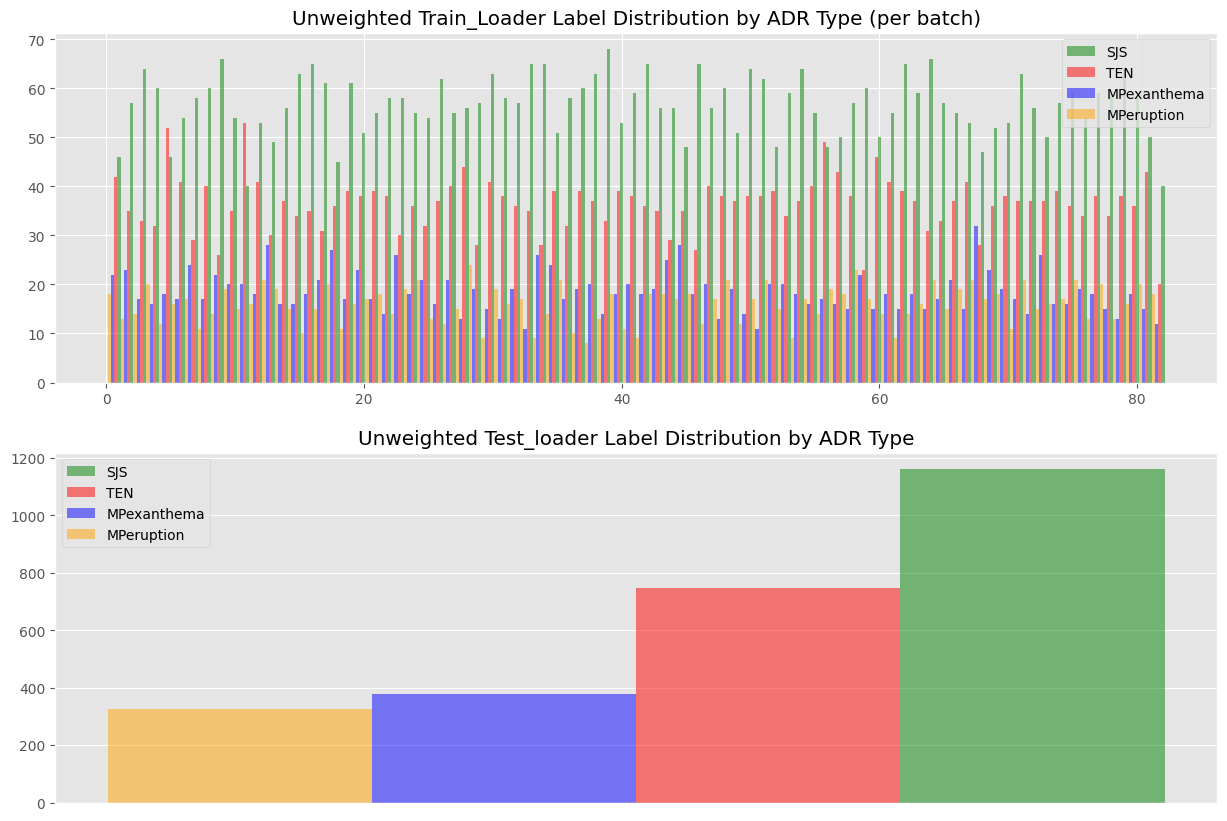

In [378]:
get_dataloader_distribution_manyclass(train_loader_unweight, test_loader_unweight, label = "Unweighted")

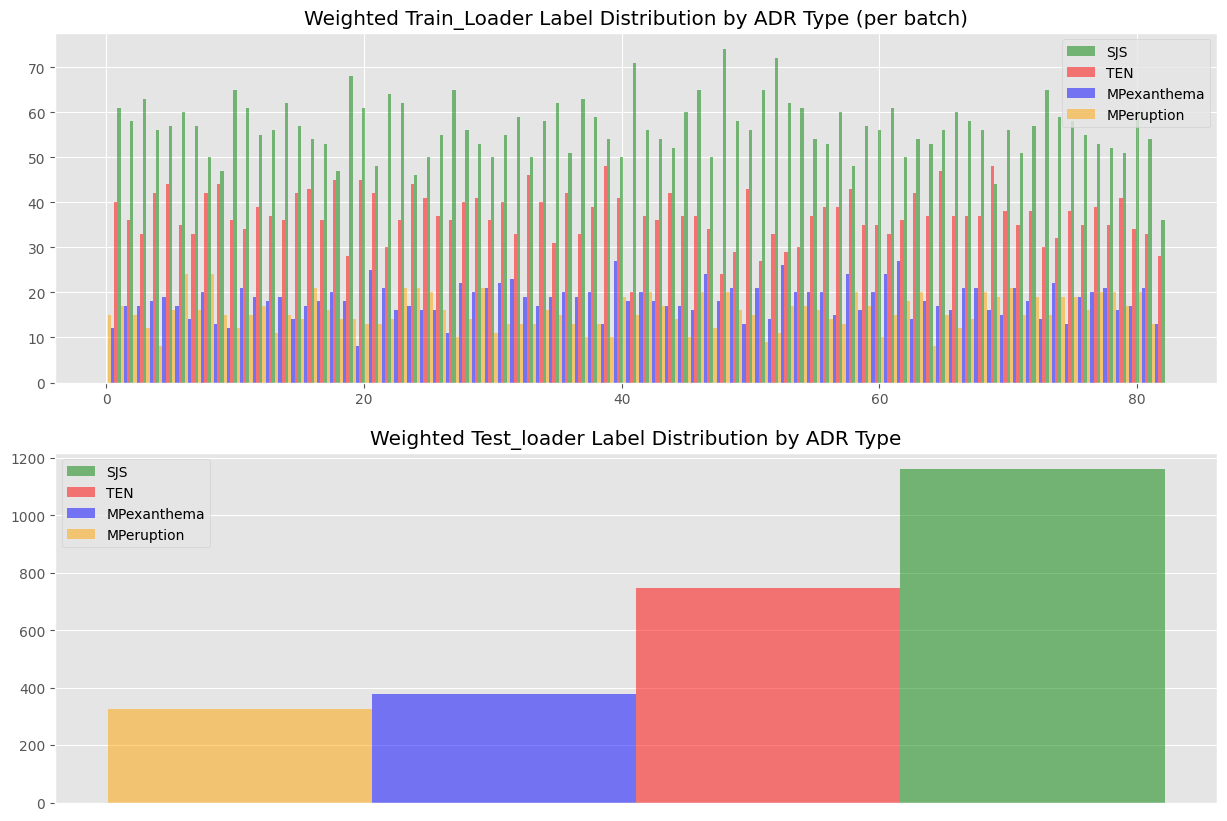

In [379]:
get_dataloader_distribution_manyclass(train_loader, test_loader, label = "Weighted")

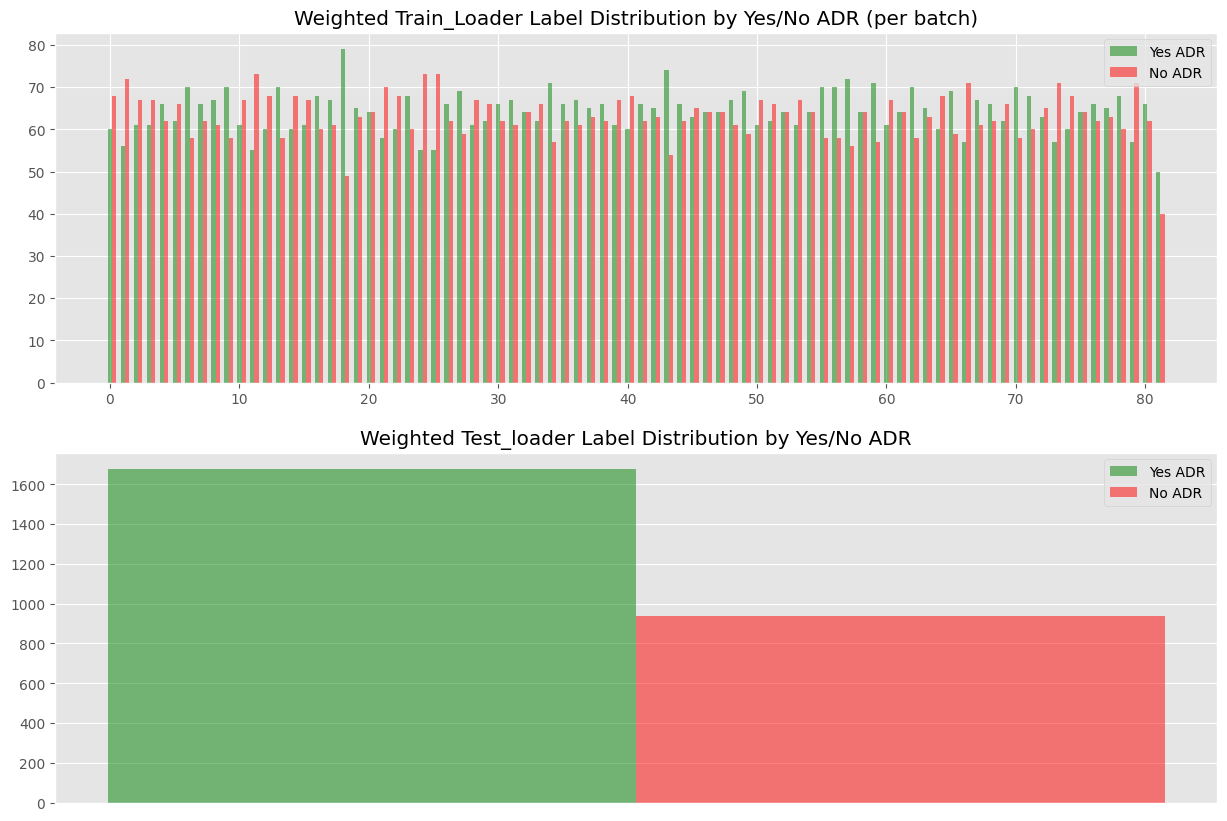

In [380]:
get_dataloader_distribution(train_loader, test_loader, label = "Weighted")

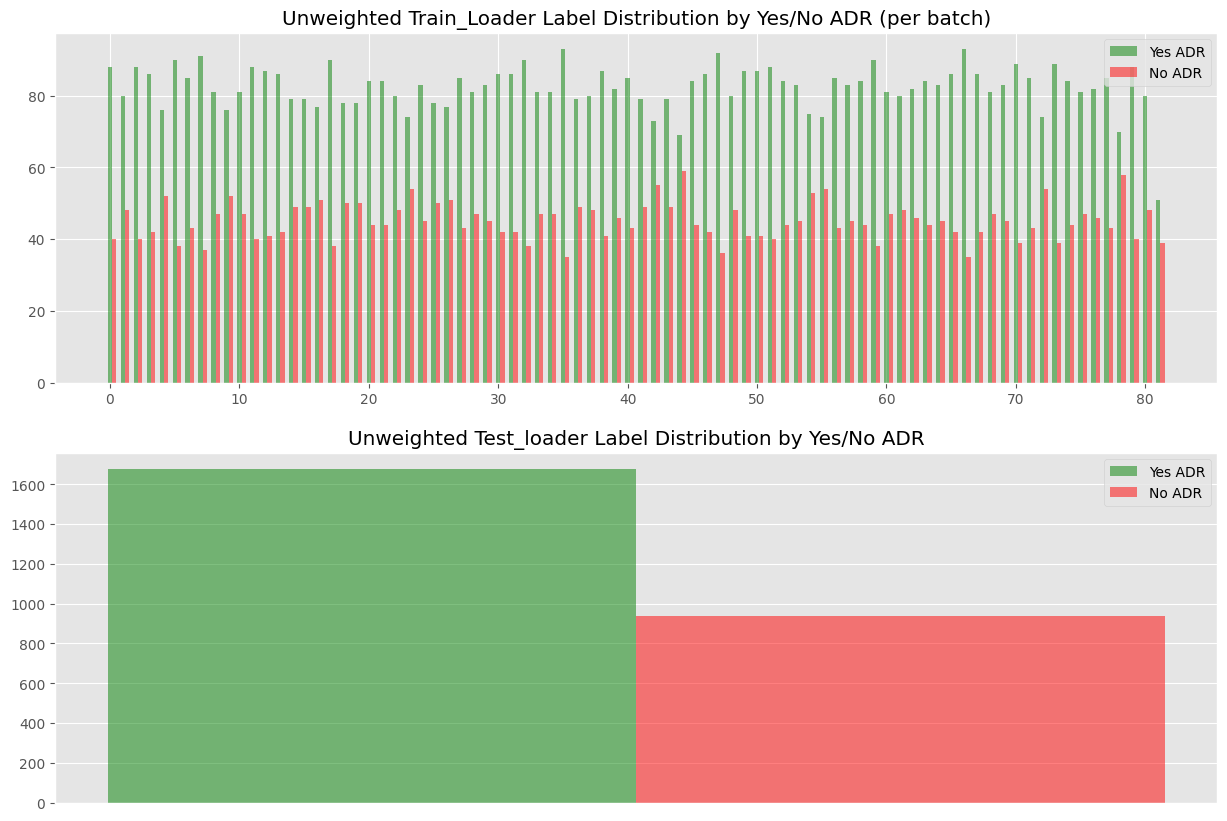

In [381]:
get_dataloader_distribution(train_loader_unweight, test_loader_unweight, label = "Unweighted")

# Evaluation

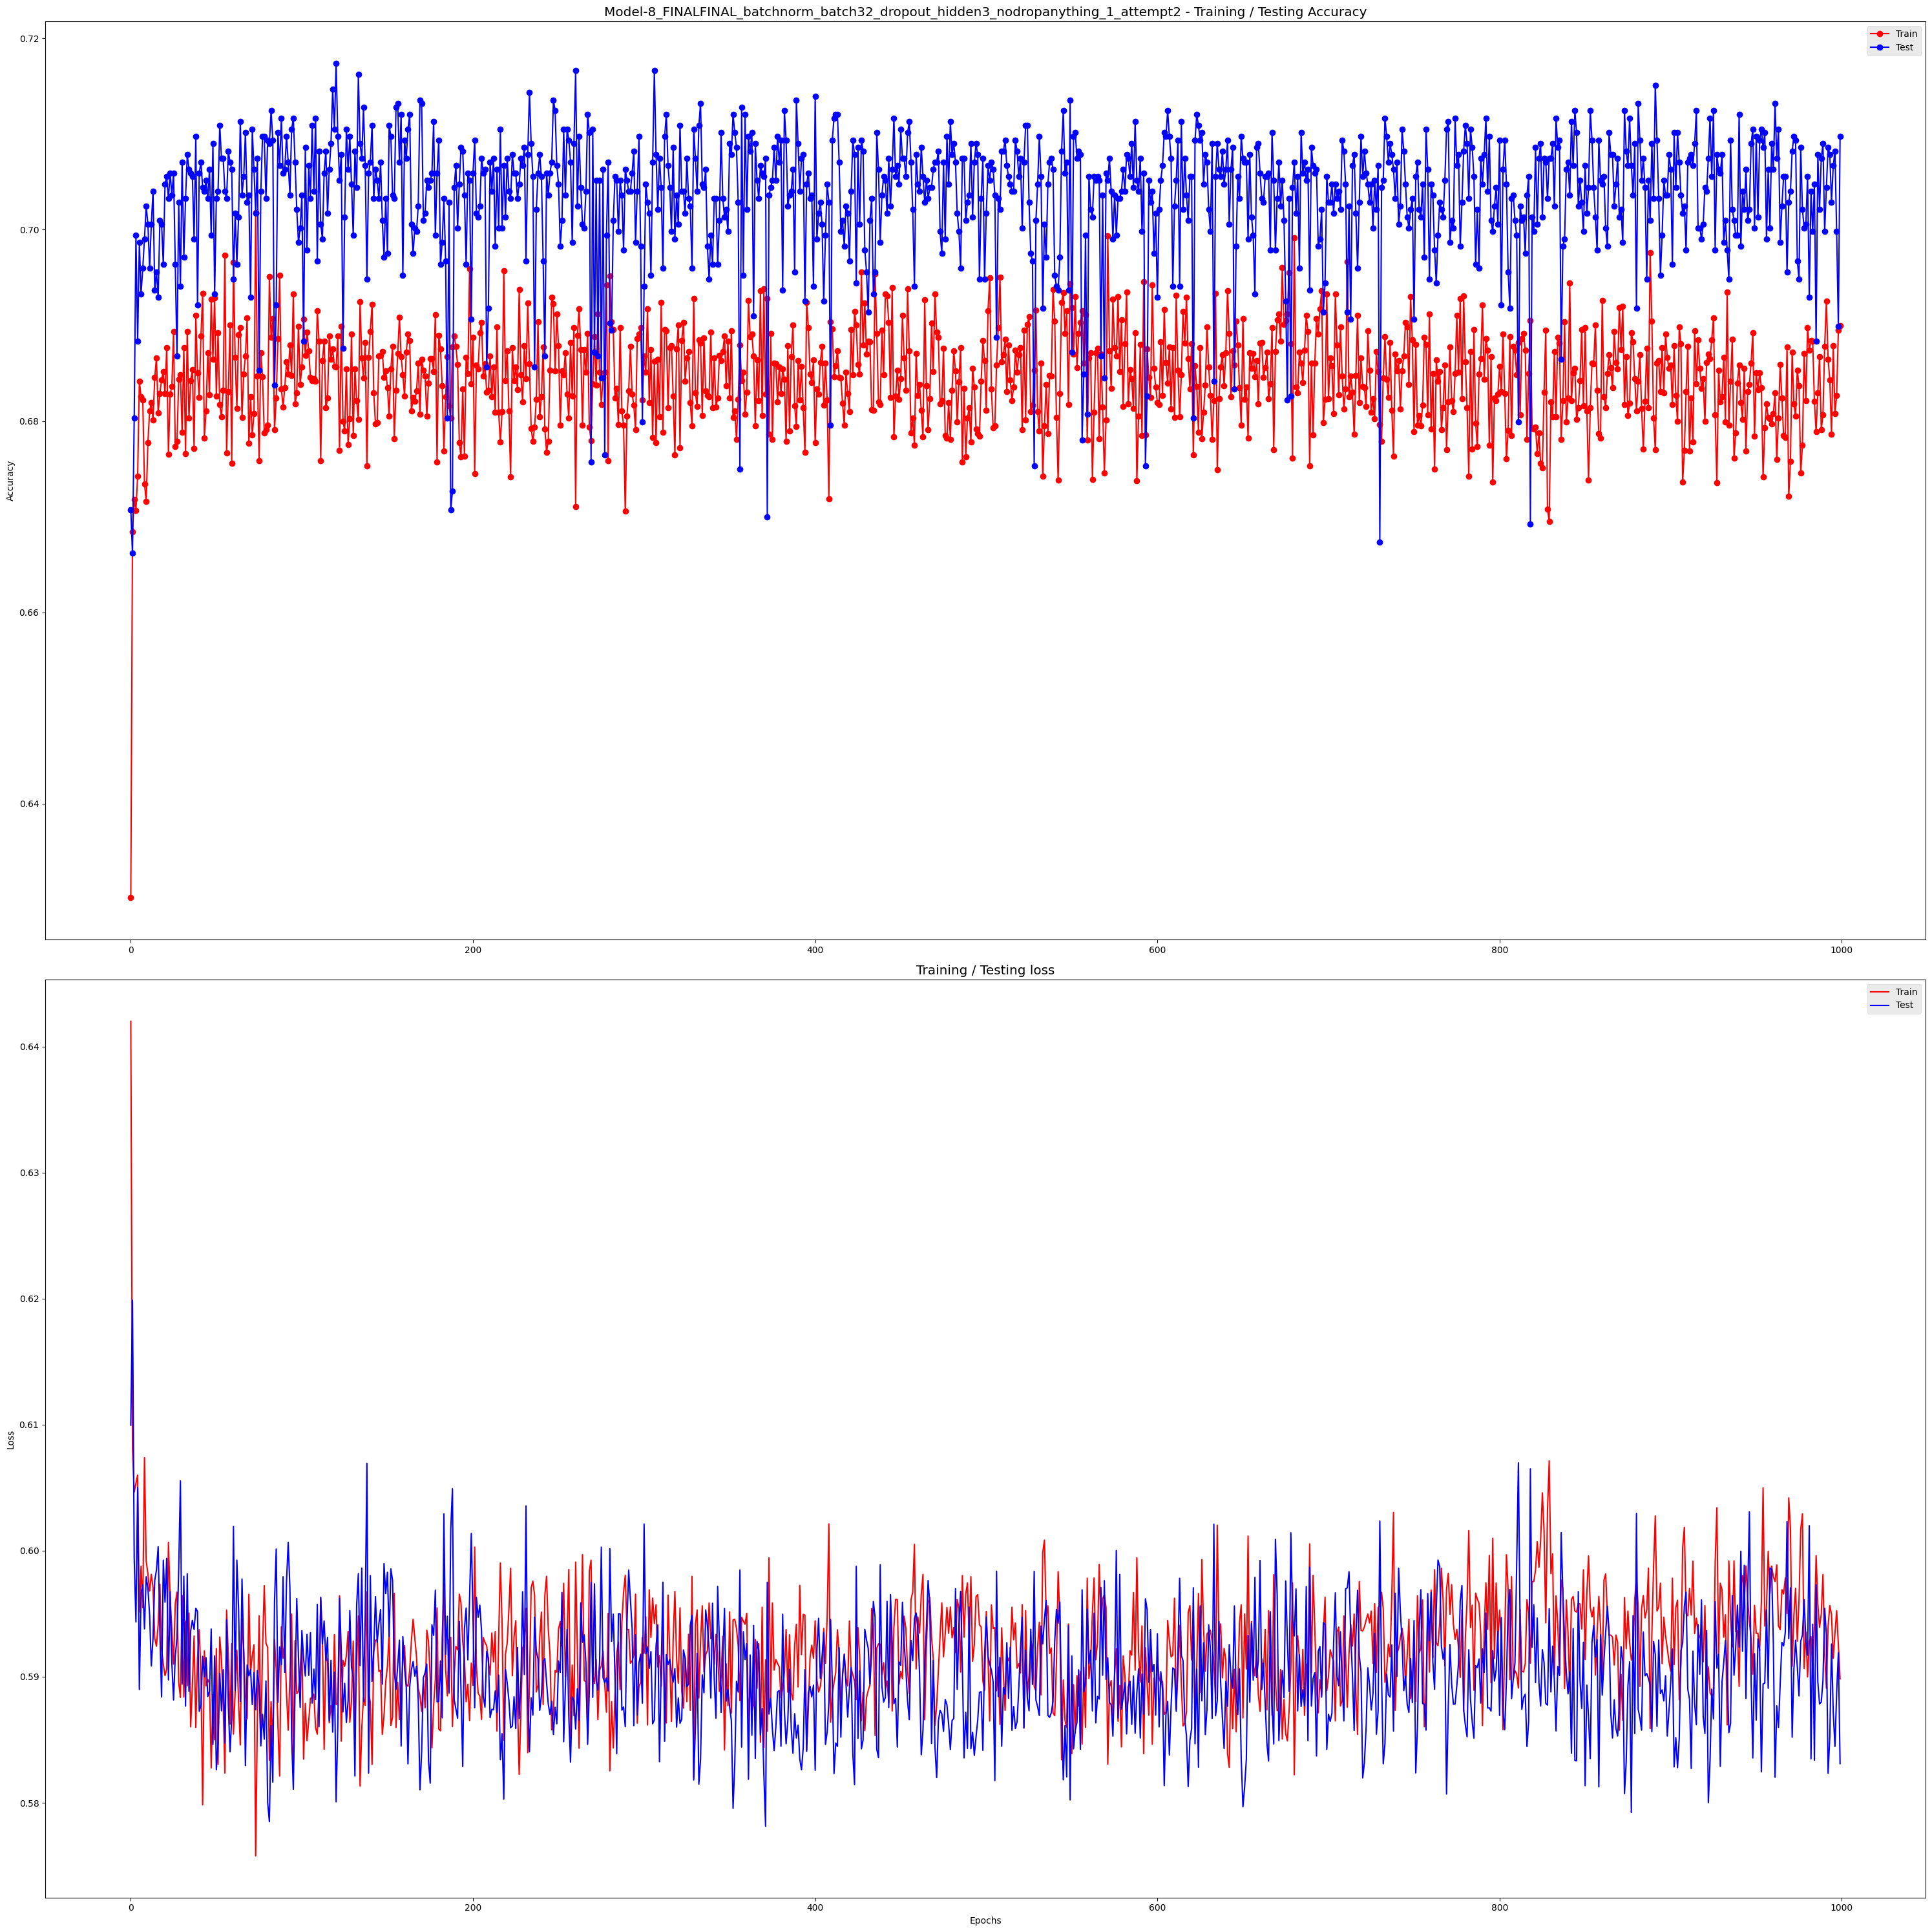

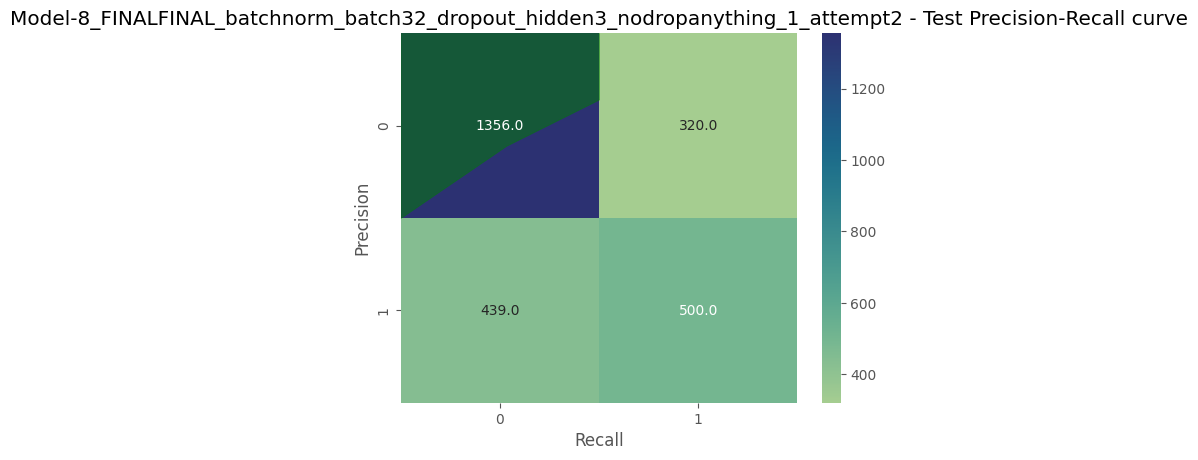

In [ ]:
# save_modeljingjing(name)
# save_graphs(name,total_train_acc,total_test_acc,total_train_loss,total_test_loss)
# save_CFmatrix(name)
# save_PRAUC(name)
# save_model(name,optimizer,loss_fn)

Network(
  (layers): Sequential(
    (0): Linear(in_features=4089, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=1024, out_features=256, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=256, out_features=1, bias=True)
    (12): Sigmoid()
  )
)
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


epoch: 0, train loss: 0.6348, test loss: 0.6113, train acc: 0.6358, test acc: 0.6551, test precision: 0.6752, test recall: 0.5150, test f1: 0.5843
epoch: 1, train loss: 0.6163, test loss: 0.6119, train acc: 0.6595, test acc: 0.6948, test precision: 0.6198, test recall: 0.5689, test f1: 0.5933
epoch: 2, train loss: 0.6115, test loss: 0.6101, train acc: 0.6673, test acc: 0.6868, test precision: 0.6187, test recall: 0.5576, test f1: 0.5866
epoch: 3, train loss: 0.6069, test loss: 0.6057, train acc: 0.6688, test acc: 0.6811, test precision: 0.6081, test recall: 0.5506, test f1: 0.5779


KeyboardInterrupt: 

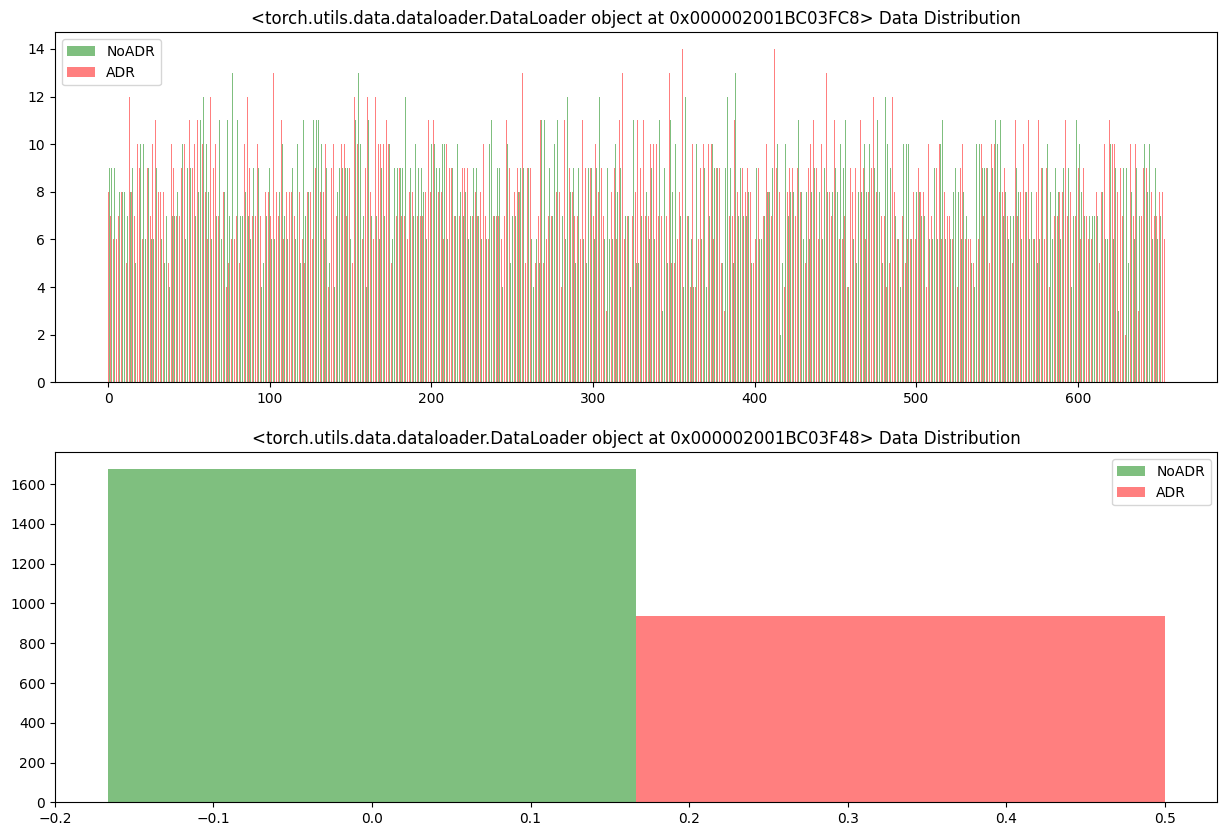

In [ ]:
# # Code variation for different batch sizes
# for x in [16]:
#     # Create model
#     model = Network().to(device)
#     print(model)

#     # Define Hyperparameters
#     batch_size = x
#     learning_rate = 2e-5
#     epochs = 50

#     # Get train, test_loader and display data distribution
#     train_loader, test_loader = get_dataloaders(batch_size)
#     get_dataloader_distribution(train_loader,test_loader)

#     # Assign Optimizer
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.01)

#     # Assign Loss Function
#     loss_fn = nn.BCELoss()

#     # Assign Run Name
#     name = f"Model-8_FINAL(checkBATCH_{x}))"
#     dir = os.path.join('logs_FINAL', name)
#     writer = SummaryWriter()
#     total_train_loss = []
#     total_test_loss = []
#     total_train_acc = []
#     total_test_acc = []

#     for t in range(epochs):
#         train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
#         test_loss, test_acc, test_precision, test_recall, test_f1 = test(test_loader, model, loss_fn)
#         print(f"epoch: {t}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}, test precision: {test_precision:.4f}, test recall: {test_recall:.4f}, test f1: {test_f1:.4f}")
#         total_train_loss.append(train_loss)
#         total_test_loss.append(test_loss)
#         total_train_acc.append(train_acc)
#         total_test_acc.append(test_acc)
#         with tf.summary.create_file_writer(f"{dir}_train").as_default():
#             tf.summary.scalar("loss", train_loss, step=t)
#             tf.summary.scalar("acc", train_acc, step=t)
#         with tf.summary.create_file_writer(f"{dir}_test").as_default():    
#             tf.summary.scalar("loss", test_loss, step=t) 
#             tf.summary.scalar("acc", test_acc, step=t)
#             tf.summary.scalar("precision", test_precision, step=t)
#             tf.summary.scalar("f1_score", test_f1, step=t)
#             tf.summary.scalar("recall_score", test_recall, step=t)
#             # trial.report(test_loss, epoch)
#     save_modeljingjing(name)
#     save_graphs(name,total_train_acc,total_test_acc,total_train_loss,total_test_loss)
#     save_CFmatrix(name)
#     save_PRAUC(name)
#     save_model(name,optimizer,loss_fn)
    


In [ ]:
writer.close()

# Save

In [ ]:
torch.save(model.state_dict(), f'../4 - Training & Testing/model_{name}.pt')

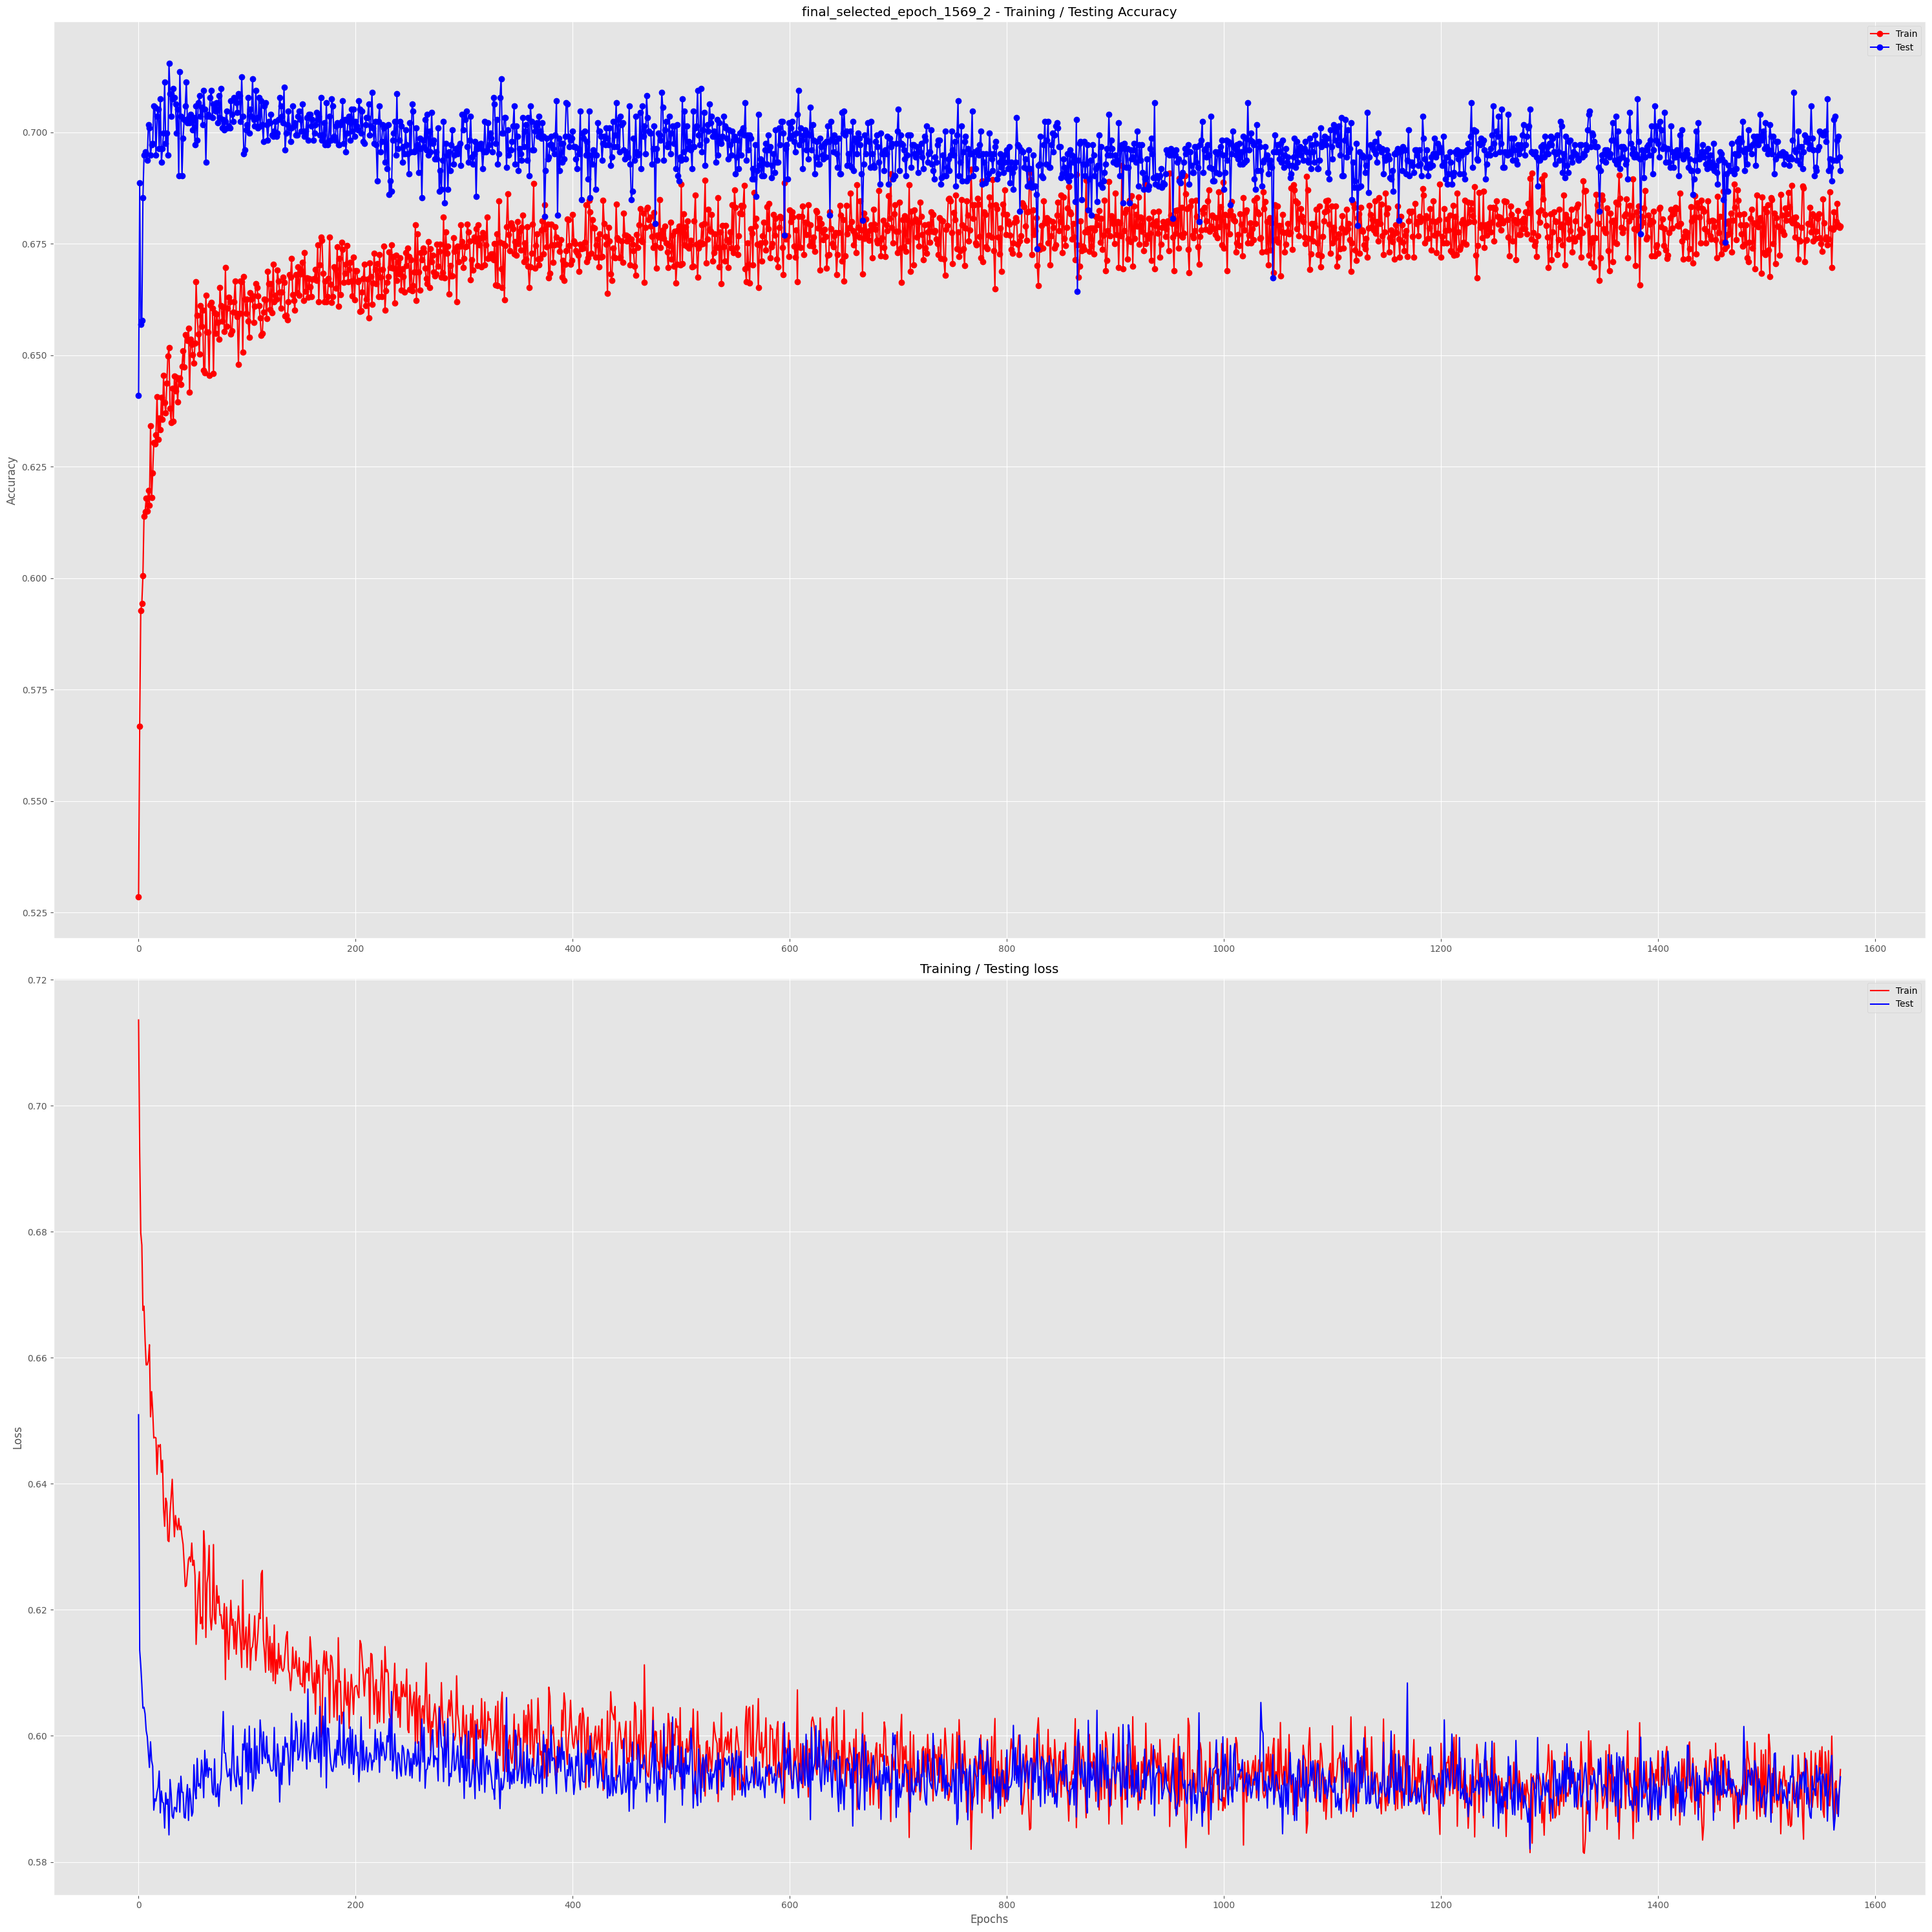

In [ ]:
fig, ax = plt.subplots(2,1)
plt.style.use('ggplot')
fig.set_figheight(30)
fig.set_figwidth(30)

ax[0].set_title(f"{name} - Training / Testing Accuracy")
ax[0].plot(total_train_acc, 'red',label='Train',marker='o')
ax[0].plot(total_test_acc,'blue',label='Test',marker='o')
#ax[0].xaxis.set(ticks=range(0,len(total_train_acc),1))
ax[0].set_ylabel("Accuracy")
ax[0].legend()
#ax[0].text(4,1,f"Model: {numberofmodel}")


ax[1].set_title("Training / Testing loss")
ax[1].set_xlabel("Epochs")
ax[1].plot(total_train_loss,label = 'Train',color='red')
ax[1].plot(total_test_loss,label = 'Test',color='blue')
#ax[1].xaxis.set(ticks=range(0,len(total_train_loss),1))
ax[1].set_ylabel("Loss")
ax[1].legend()
#plt.show()

plt.tight_layout()#h_pad = 3, w_pad=3)
plt.savefig(f"../4 - Training & Testing/model_graph_{name}.png")

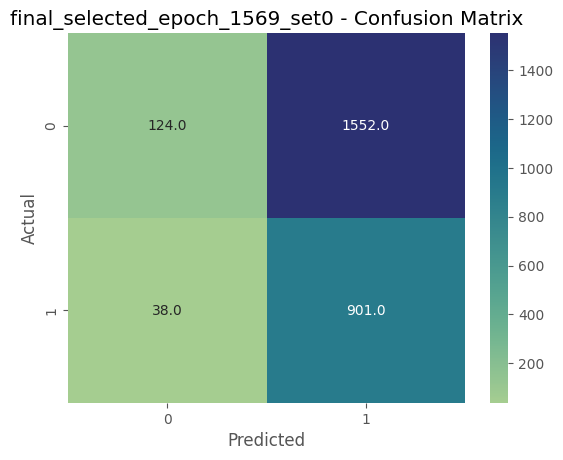

In [401]:
import seaborn as sns


with torch.no_grad():
    data = test_loader.dataset.tensors[0].to(device)
    predicted = model(data).to(device)
    predicted = predicted.cpu()
    predicted = predicted.flatten()
    predicted = torch.round(predicted)
    target = test_loader.dataset.tensors[1].flatten()

cf_matrix = confusion_matrix(target, predicted)
fig, ax = plt.subplots()
ax = sns.heatmap(cf_matrix, annot=True, fmt=".1f",cmap="crest")
ax.set_title(f"{name} - Confusion Matrix")
ax.set(xlabel='Predicted', ylabel='Actual')
ax_fig = ax.get_figure()
ax_fig.savefig(f"../4 - Training & Testing/model_cf_{name}.png")
# disp.plot(xticks_rotation=90)


Text(0.5, 1.0, 'final_selected_epoch_1569_2 - Test Precision-Recall curve')

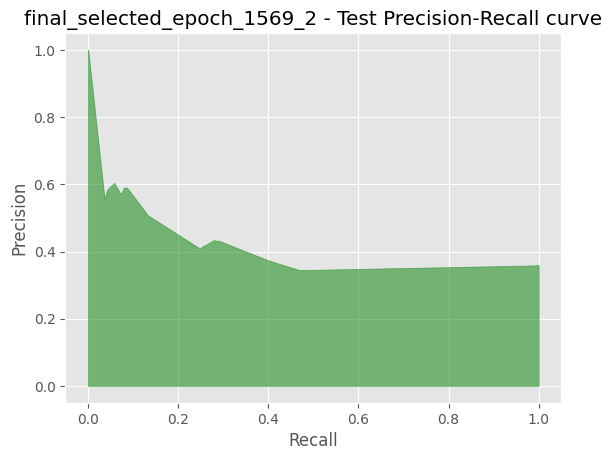

In [347]:
with torch.no_grad():
    data = test_loader.dataset.tensors[0].to(device)
    predicted = model(data).to(device)
    predicted = predicted.cpu()
    predicted = predicted.flatten()
    #predicted = torch.round(predicted)
    target = test_loader.dataset.tensors[1].flatten()
precision, recall, thresholds = precision_recall_curve(target, predicted,pos_label=1)
plt.fill_between(recall, precision, alpha=0.5, color='g')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title(f"{name} - Test Precision-Recall curve")
plt.savefig(f"../4 - Training & Testing/model_PRAUC_{name}.png")

In [ ]:

f = open(f"../4 - Training & Testing/models/{name}.txt",'w')
f.write(f"{str(optimizer)} \n\n{str(loss_fn)} \n\n {str(df_input.columns)}")
f.close()

# just note

In [ ]:
def save_modeljingjing(name):
    torch.save(model.state_dict(), f'../4 - Training & Testing/models/model_{name}.pt')

In [ ]:
def save_graphs(name,total_train_acc,total_test_acc,total_train_loss,total_test_loss):
    fig, ax = plt.subplots(2,1)
    plt.style.use('ggplot')
    fig.set_figheight(30)
    fig.set_figwidth(30)

    ax[0].set_title(f"{name} - Training / Testing Accuracy")
    ax[0].plot(total_train_acc, 'red',label='Train',marker='o')
    ax[0].plot(total_test_acc,'blue',label='Test',marker='o')
    #ax[0].xaxis.set(ticks=range(0,len(total_train_acc),1))
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()
    #ax[0].text(4,1,f"Model: {numberofmodel}")


    ax[1].set_title("Training / Testing loss")
    ax[1].set_xlabel("Epochs")
    ax[1].plot(total_train_loss,label = 'Train',color='red')
    ax[1].plot(total_test_loss,label = 'Test',color='blue')
    #ax[1].xaxis.set(ticks=range(0,len(total_train_loss),1))
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    #plt.show()

    plt.tight_layout()#h_pad = 3, w_pad=3)
    plt.savefig(f"../4 - Training & Testing/models/model_graph_{name}.png")

In [ ]:
def save_CFmatrix(name):

    import seaborn as sns


    with torch.no_grad():
        data = test_loader.dataset.tensors[0].to(device)
        predicted = model(data).to(device)
        predicted = predicted.cpu()
        predicted = predicted.flatten()
        predicted = torch.round(predicted)
        target = test_loader.dataset.tensors[1].flatten()

    cf_matrix = confusion_matrix(target, predicted)
    fig, ax = plt.subplots()
    ax = sns.heatmap(cf_matrix, annot=True, fmt=".1f",cmap="crest")
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set(xlabel='Predicted', ylabel='Actual')
    ax_fig = ax.get_figure()
    ax_fig.savefig(f"../4 - Training & Testing/models/model_cf_{name}.png")
    # disp.plot(xticks_rotation=90)
    


In [ ]:
def save_PRAUC(name):
    with torch.no_grad():
        data = test_loader.dataset.tensors[0].to(device)
        predicted = model(data).to(device)
        predicted = predicted.cpu()
        predicted = predicted.flatten()
        predicted = torch.round(predicted)
        target = test_loader.dataset.tensors[1].flatten()
    precision, recall, thresholds = precision_recall_curve(target, predicted)
    plt.fill_between(recall, precision, alpha=0.5, color='g')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title(f"{name} - Test Precision-Recall curve")
    plt.savefig(f"../4 - Training & Testing/models/model_PRAUC_{name}.png")

In [ ]:
from torchsummary import summary
summary(model.cuda(),(1,1,df_input.shape[1]))

ValueError: expected 2D or 3D input (got 4D input)

In [ ]:
def save_model(name,optimizer,loss_fn):
    f = open(f"../4 - Training & Testing/models/{name}.txt",'w')
    f.write(f"{str(optimizer)} \n\n{str(loss_fn)} \n\n {str(df_input.columns)}")
    f.close()